In [1]:
# import statements

import matplotlib.pyplot as plt
from __future__ import division
import os, sys, random
import numpy as np

# function to draw the table for Values and greedy policy
from utilities import *

is_latex_output_needed = False # make it true to get latex table outputs

In [2]:
# constant definitions
actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

<img src='./maze.png' width=400 align='left'/>

In [3]:
# check if the state, we end up after taking an action is a valid state
# especially to check the corner cases
def get_valid_state(prev_state, curr_state):
    # check the validity of the current state
    if((curr_state[0] >= 0 and curr_state[0] < 10) and
       (curr_state[1] >= 0 and curr_state[1] < 10)):
        
        # if the next state is valid, return the state         
        return curr_state
    else:
        return prev_state
        

In [4]:
# function to get the next state after performing the action
def get_state(current_state, action):
    next_state = None
    
    if action == 'UP':
        next_state = get_valid_state(current_state, 
                                     (current_state[0] - 1, current_state[1]))
    elif action == 'DOWN':
        next_state = get_valid_state(current_state,
                                     (current_state[0] + 1, current_state[1]))
    elif action == 'LEFT':
        next_state = get_valid_state(current_state,
                                     (current_state[0], current_state[1] - 1))
    else: # RIGHT
        next_state = get_valid_state(current_state,
                                     (current_state[0], current_state[1] + 1))
    
    return next_state

In [5]:
# get the other uncertain actions (with probability 0.2/3) associated
# with an action
def get_uncertain_actions(action):
    all_actions = list(actions)
    assert action in all_actions, action + ' is not in all_actions'
    all_actions.remove(action)
    return all_actions

In [6]:
# get the next state after taking an action
def get_transition_states(current_state, action):
    transitions = []
    
    # handle the grey IN states (transition is independent of action)
    if current_state in [(0, 7)]:
        transitions += [[0.25, (2, 2)], [0.25, (3, 2)], [0.25, (4, 2)], [0.25, (5, 2)]]
    
    # handle the brown IN states (transition is independent of action)
    elif current_state in [(9, 0)]:
        transitions.append([1, (8, 7)])
    
    elif current_state == GOAL:
        # do nothing, stay in same state
        pass
    
    else:
        # handle actual states and actions
        transitions.append([0.8, get_state(current_state, action)])
        
        uncertain_actions = get_uncertain_actions(action)
        for uncert_action in uncertain_actions:
            transitions.append([0.2/3, get_state(current_state, uncert_action)])
    
    return transitions

In [7]:
# to get all the states of the grid for value iteration
def get_states_enumeration(is_random=True):
    x, y = np.meshgrid(np.arange(10), np.arange(10))
    states = list(zip(x.reshape(-1), y.reshape(-1)))
    
    if is_random:
        random.shuffle(states)
    
    return states

In [8]:
# function to return immediate reward
def get_immediate_reward(state):
    if state == GOAL:
        return +10
    else:
        return 0
    

In [9]:
# calculation of value for a particular state and action by having the 
# previous value table in mind
def get_value(state, action, V, alpha = 0.7):
    transitions = get_transition_states(state, action)
    
    current_value = 0
    
    # for each transition from the state, calculate expected return
    for transition in transitions:
        probability = transition[0]
        target_state = transition[1]        
        current_value += (probability * (get_immediate_reward(target_state)
                                         + (alpha * V[target_state])))
    
    return current_value
    

# Value iteration

In [10]:
# function to perform value iteration
def value_iteration(GOAL):
    V_trace = []
    policy_trace = []

    max_costs = []
    N = 10

    # initialize value of all states
    V = np.zeros((N, N))
    pi = np.chararray(V.shape)
    eps = 1e-10

    is_stop = False
    
    # loop for value iteration
    while not is_stop:
        prev_V = V.copy()
        V = np.zeros((N, N))
        
        # get all the states for performing VI
        states = get_states_enumeration()

        for state in states:
            # do not update value for GOAL state
            if state == GOAL:
                continue

            current_values = []
            
            # for each action in a state, get the values
            for action in actions:
                current_values.append(get_value(state, action, prev_V))

            # find the max value and greedy policy
            V[state] = max(current_values)
            pi[state] = actions[np.argmax(current_values)][0]

        # check for stopping condition
        max_error = np.max(np.abs(prev_V - V))
        max_costs.append(max_error)
        
        # note down the V,pi after 10, 25 iterations
        if len(max_costs) in [10, 25]:
            V_trace.append(V.copy())
            policy_trace.append(pi.copy())
            
        if max_error <= eps:
            is_stop = True

    print('In total, ', len(max_costs), ' iterations')
    # V,pi after VI is stopped
    V_trace.append(V.copy())
    policy_trace.append(pi.copy())
    return V, pi, max_costs, V_trace, policy_trace

In [11]:
def plot_graph(max_costs, filename):
    # function to plot line graph
    plt.plot(range(len(max_costs)), max_costs)
    plt.xlabel('iterations')
    plt.ylabel('difference between consecutive max values')
    plt.title('iterations vs value difference')
    plt.savefig(filename)    

('In total, ', 47, ' iterations')
   0  1  2  3  4  5  6  7  8  9
0  R  R  R  R  R  D  D  U  R  �
1  R  R  R  R  R  R  R  R  R  U
2  R  R  R  R  R  R  R  R  U  U
3  R  R  R  R  R  R  R  R  U  U
4  U  R  R  R  R  R  R  U  U  U
5  U  R  R  R  R  R  U  U  U  U
6  D  R  R  R  R  U  U  U  U  U
7  D  D  R  R  R  U  U  U  U  U
8  D  D  L  R  R  R  U  U  U  U
9  U  L  L  L  R  R  R  U  U  U


       0      1      2      3      4      5      6      7      8      9
0  0.102  0.155  0.238  0.367  0.562  0.859  1.290  0.106  8.678  0.000
1  0.126  0.197  0.314  0.504  0.811  1.308  2.115  3.434  5.749  8.948
2  0.103  0.160  0.251  0.395  0.620  0.972  1.521  2.377  3.703  5.610
3  0.072  0.110  0.170  0.265  0.412  0.639  0.991  1.537  2.381  3.520
4  0.047  0.072  0.111  0.172  0.267  0.413  0.640  0.992  1.529  2.210
5  0.031  0.046  0.072  0.111  0.172  0.267  0.413  0.640  0.980  1.389
6  0.031  0.031  0.046  0.072  0.111  0.172  0.267  0.412  0.628  0.874
7  0.047  0.032  0.031  0.046  0.072

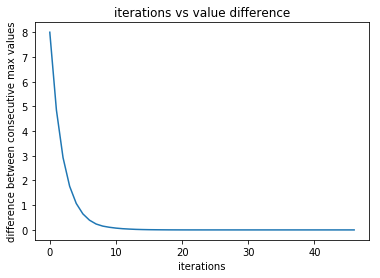

In [12]:
# Q1.1
# perform value iteration and display greedy policy and value table
GOAL = (0, 9) 
V, pi, max_costs, V_trace, pi_trace = value_iteration(GOAL)
display_table(pi, is_latex_output_needed)
display_table(np.around(V, decimals=3), is_latex_output_needed)
plot_graph(max_costs, 'goal1.png')

In [13]:
# show the V values and policy after 10, 25, end of iterations
for i, (_v, _pi) in enumerate(zip(V_trace, pi_trace)):
    display_table(_pi, is_latex_output_needed)
    display_table(np.around(_v, decimals=3), is_latex_output_needed)

   0  1  2  3  4  5  6  7  8  9
0  U  R  R  R  R  D  D  U  R  �
1  R  R  R  R  R  R  R  R  R  U
2  U  R  R  R  R  R  R  R  U  U
3  U  U  R  R  R  R  R  R  U  U
4  U  U  U  R  R  R  R  U  U  U
5  U  U  U  U  R  R  U  U  U  U
6  U  U  U  U  U  U  U  U  U  U
7  U  U  U  U  U  U  U  U  U  U
8  U  U  U  U  U  U  U  U  U  U
9  U  U  U  U  U  U  U  U  U  U


       0      1      2      3      4      5      6      7      8      9
0  0.000  0.066  0.140  0.306  0.504  0.832  1.264  0.023  8.673  0.000
1  0.047  0.088  0.251  0.433  0.782  1.281  2.105  3.425  5.747  8.947
2  0.000  0.078  0.139  0.339  0.557  0.949  1.501  2.371  3.699  5.608
3  0.000  0.000  0.087  0.151  0.357  0.577  0.969  1.517  2.375  3.516
4  0.000  0.000  0.000  0.088  0.152  0.358  0.578  0.969  1.509  2.202
5  0.000  0.000  0.000  0.000  0.088  0.152  0.358  0.578  0.957  1.367
6  0.000  0.000  0.000  0.000  0.000  0.088  0.152  0.357  0.565  0.840
7  0.000  0.000  0.000  0.000  0.000  0.000  0.088  0.151  0.342  0.48

('In total, ', 42, ' iterations')
   0  1  2  3  4  5  6  7  8  9
0  D  D  D  D  D  R  R  U  L  L
1  D  D  D  D  D  D  U  U  U  L
2  D  D  D  D  D  D  D  U  U  U
3  D  D  D  D  D  D  D  L  L  L
4  D  D  D  D  D  D  D  D  D  D
5  D  D  D  D  D  D  D  D  D  D
6  D  D  D  D  D  D  D  L  L  D
7  R  R  D  D  D  D  L  L  L  L
8  R  R  D  D  D  L  L  L  L  L
9  U  R  R  d  L  L  L  L  L  L


       0      1      2      3      4      5      6      7      8      9
0  0.082  0.114  0.163  0.201  0.170  0.243  0.384  0.612  0.384  0.245
1  0.124  0.173  0.251  0.314  0.252  0.184  0.250  0.377  0.248  0.163
2  0.189  0.268  0.394  0.503  0.394  0.267  0.186  0.236  0.160  0.107
3  0.290  0.415  0.618  0.806  0.618  0.414  0.269  0.180  0.120  0.082
4  0.442  0.644  0.969  1.294  0.970  0.642  0.416  0.269  0.175  0.120
5  0.675  0.997  1.518  2.082  1.519  0.997  0.645  0.416  0.269  0.182
6  1.030  1.545  2.373  3.357  2.375  1.547  0.999  0.645  0.417  0.278
7  1.568  2.392  3.703  5.426  3.706

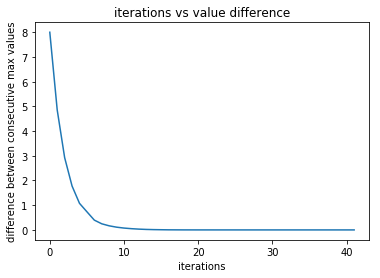

In [14]:
# Q1.1
# perform value iteration and display greedy policy and value table
GOAL = (9, 3) 
V, pi, max_costs, V_trace, pi_trace = value_iteration(GOAL)
display_table(pi, is_latex_output_needed)
display_table(np.around(V, decimals=3), is_latex_output_needed)
plot_graph(max_costs, 'goal1.png')

In [15]:
# show the V values and policy after 10, 25, end of iterations
for i, (_v, _pi) in enumerate(zip(V_trace, pi_trace)):
    display_table(_pi, is_latex_output_needed)
    display_table(np.around(_v, decimals=3), is_latex_output_needed)

   0  1  2  3  4  5  6  7  8  9
0  U  U  D  D  D  R  R  U  L  L
1  U  D  D  D  D  D  U  U  U  L
2  D  D  D  D  D  D  D  U  U  U
3  D  D  D  D  D  D  D  D  U  U
4  D  D  D  D  D  D  D  D  D  U
5  D  D  D  D  D  D  D  D  L  L
6  D  D  D  D  D  D  D  L  L  D
7  R  R  D  D  D  D  L  L  L  L
8  R  R  D  D  D  L  L  L  L  L
9  U  R  R  d  L  L  L  L  L  L


       0      1      2      3      4      5      6      7      8      9
0  0.000  0.000  0.076  0.082  0.082  0.148  0.305  0.550  0.305  0.152
1  0.000  0.086  0.133  0.246  0.136  0.096  0.155  0.298  0.155  0.065
2  0.088  0.149  0.336  0.416  0.336  0.153  0.097  0.142  0.063  0.023
3  0.181  0.357  0.550  0.774  0.550  0.358  0.156  0.093  0.023  0.000
4  0.381  0.582  0.946  1.261  0.946  0.578  0.361  0.154  0.088  0.000
5  0.624  0.974  1.496  2.073  1.497  0.975  0.581  0.361  0.153  0.088
6  1.007  1.525  2.367  3.350  2.369  1.526  0.977  0.581  0.361  0.167
7  1.551  2.386  3.699  5.424  3.702  2.392  1.527  0.976  0.581  0.36

# Policy iteration

In [16]:
def policy_estimation(policy, alpha=0.7):
    # create simultaneous equation coeff matrix
    states_enumeration = get_states_enumeration(is_random = False)
    
    A = np.zeros((0, N*N))
    b = np.zeros((N, N))
    
    # for each state, create the coeff row
    for state in states_enumeration:
        current_row = np.zeros((N, N))
        
        # put coeffs in particular position
        current_row[state] = 1
        transitions = get_transition_states(state, actions[int(policy[state])])
        
        #for each transitioned state, assign the coeff
        for prob, target_state in transitions:
            current_row[target_state] += (-alpha * prob)
            b[state] += (prob * get_immediate_reward(target_state))
        
        A = np.vstack((A, current_row.reshape(-1)))
    
    V = np.matmul(np.linalg.pinv(A), b.reshape(N*N, 1))
    return V.reshape(N, N)

In [17]:
def policy_improvement(V):
    new_policy = np.zeros((N, N))
    
    states_enumeration = get_states_enumeration(is_random = False)
    
    for state in states_enumeration:
        all_action_V = []
        for action in actions:
            all_action_V.append(get_value(state, action, V))
        
        new_policy[state] = np.argmax(all_action_V)
    
    return new_policy

In [19]:
N = 10
GOAL = (9, 3) 
policy = np.zeros((N, N))

while True:
    V = policy_estimation(policy)
    new_policy = policy_improvement(V)
    
    if not (np.abs(new_policy - policy).sum() > 0):
        break
    
    policy = new_policy

char_policy_func = np.vectorize(lambda i: actions[int(i)][0])
display_table(char_policy_func(policy), is_latex_output_needed)
display_table(np.around(V, decimals=3), is_latex_output_needed)

(100, 100)
(100, 1)
(100, 100)
(100, 1)
(100, 100)
(100, 1)
(100, 100)
(100, 1)
(100, 100)
(100, 1)
   0  1  2  3  4  5  6  7  8  9
0  R  R  R  R  R  D  D  U  D  D
1  R  R  R  R  R  R  R  R  D  D
2  R  R  R  R  R  R  R  R  R  R
3  R  R  R  R  R  R  R  R  R  U
4  R  R  R  R  R  R  R  R  R  R
5  R  R  R  R  R  R  R  R  U  U
6  D  R  R  R  R  R  R  U  U  U
7  D  D  U  R  R  R  U  U  U  U
8  D  L  L  D  R  R  U  U  U  U
9  U  L  R  U  L  R  R  R  U  U


       0      1      2      3      4      5      6       7       8       9
0  0.197  0.296  0.452  0.690  1.053  1.603  2.339   0.645   5.987   9.173
1  0.276  0.421  0.654  1.015  1.577  2.447  3.794   5.887   9.373  14.353
2  0.389  0.602  0.949  1.496  2.359  3.720  5.863   9.239  14.553  22.889
3  0.453  0.706  1.122  1.787  2.848  4.543  7.254  11.598  18.565  15.474
4  0.391  0.604  0.952  1.501  2.366  3.728  5.873   9.247  14.553  22.888
5  0.284  0.427  0.664  1.035  1.612  2.507  3.897   6.050   9.383  14.344
6  0.291  0.292  0.43